In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="uN1O0EDdiSuJbSsnD4bb")
project = rf.workspace("tpva").project("album-genre")
version = project.version(1)
dataset = version.download("folder")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Album-Genre-1 in folder:: 100%|██████████| 4632/4632 [00:01<00:00, 3086.76it/s]


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_dir = '/content/Album-Genre-1/train'
validation_dir = '/content/Album-Genre-1/valid'
test_dir = '/content/Album-Genre-1/test'

In [5]:
# Parameters
BATCH_SIZE = 50
IMG_SIZE = 224
NUM_WORKERS = 2

In [6]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
# Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(validation_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)


In [8]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [9]:
# Class names and number of classes
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")


Number of classes: 14


In [10]:
# Define the model
class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetClassifier, self).__init__()
        self.base_model = models.efficientnet_b0(weights="IMAGENET1K_V1")
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

In [11]:
model = EfficientNetClassifier(num_classes).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 89.1MB/s]


In [12]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

In [14]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, metric):
        if self.best_score is None or metric > self.best_score + self.delta:
            self.best_score = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [15]:
# Training loop with model saving
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=1, save_interval=1, patience=3):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    # Early stopping variables
    best_val_acc = 0.0
    early_stop_counter = 0

    for epoch in tqdm(range(num_epochs)):
        # Training
        model.train()
        running_loss, correct = 0.0, 0
        for inputs, labels in tqdm(train_loader, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # Validation
        model.eval()
        running_loss, correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                correct += (outputs.argmax(1) == labels).sum().item()

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Adjust learning rate
        scheduler.step(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save model every save_interval epochs
        if (epoch + 1) % save_interval == 0:
            model_filename = f"modelTorch_{epoch+1}epochs_Rebalanced.pth"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, model_filename)
            print(f"Model saved as {model_filename}")

        # Early stopping logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_counter = 0  # Reset counter if improvement
        else:
            early_stop_counter += 1
            print(f"No improvement for {early_stop_counter} epoch(s).")

        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    return history

In [16]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, save_interval=1, patience=3)

 10%|█         | 1/10 [14:56<2:14:30, 896.67s/it]

Epoch 1/10: Train Loss: 2.5106, Train Acc: 0.1502, Val Loss: 2.4834, Val Acc: 0.1689
Model saved as modelTorch_1epochs_Rebalanced.pth



 20%|██        | 2/10 [29:12<1:56:23, 872.93s/it]

Epoch 2/10: Train Loss: 2.0896, Train Acc: 0.3134, Val Loss: 2.5205, Val Acc: 0.1907
Model saved as modelTorch_2epochs_Rebalanced.pth



 30%|███       | 3/10 [43:22<1:40:34, 862.03s/it]

Epoch 3/10: Train Loss: 1.6554, Train Acc: 0.4667, Val Loss: 2.8803, Val Acc: 0.2038
Model saved as modelTorch_3epochs_Rebalanced.pth



 40%|████      | 4/10 [57:41<1:26:05, 860.85s/it]

Epoch 4/10: Train Loss: 1.1483, Train Acc: 0.6262, Val Loss: 3.2072, Val Acc: 0.1485
Model saved as modelTorch_4epochs_Rebalanced.pth
No improvement for 1 epoch(s).



 50%|█████     | 5/10 [1:11:51<1:11:25, 857.14s/it]

Epoch 5/10: Train Loss: 0.7523, Train Acc: 0.7695, Val Loss: 3.7476, Val Acc: 0.1528
Model saved as modelTorch_5epochs_Rebalanced.pth
No improvement for 2 epoch(s).



 50%|█████     | 5/10 [1:26:03<1:26:03, 1032.61s/it]

Epoch 6/10: Train Loss: 0.6688, Train Acc: 0.7813, Val Loss: 3.7276, Val Acc: 0.1834
Model saved as modelTorch_6epochs_Rebalanced.pth
No improvement for 3 epoch(s).
Early stopping triggered after 6 epochs.


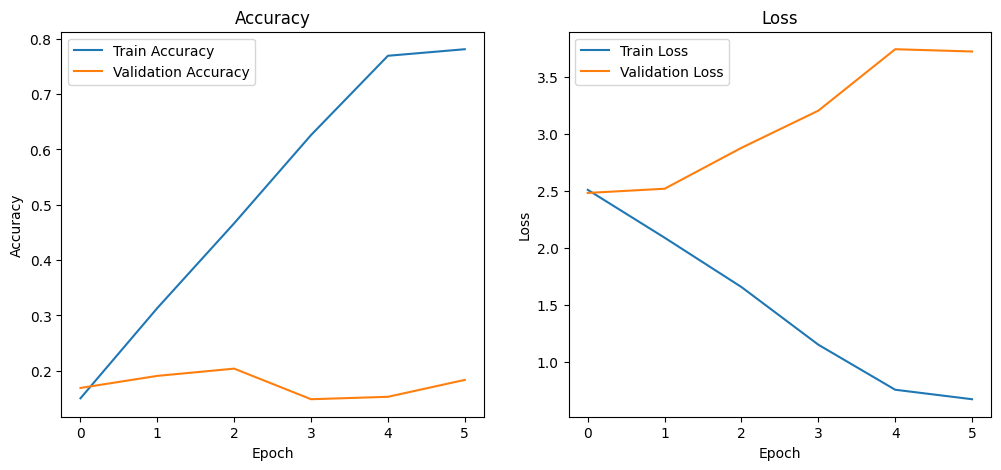

In [17]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

F1 Score: 0.9577
              precision    recall  f1-score   support

      class1       0.95      0.97      0.96       343
     class11       0.97      0.94      0.96       302
     class12       0.99      0.96      0.97       354
     class13       0.97      0.96      0.97       121
     class14       0.99      0.94      0.96       258
     class15       0.90      0.95      0.92       137
      class2       0.92      0.98      0.95       357
      class3       0.95      0.93      0.94       110
      class4       0.97      0.96      0.96       167
      class5       0.97      0.95      0.96       321
      class6       0.93      0.94      0.94       137
      class7       0.97      0.98      0.97       137
      class8       0.99      0.97      0.98       119
      class9       0.94      0.97      0.95       347

    accuracy                           0.96      3210
   macro avg       0.96      0.96      0.96      3210
weighted avg       0.96      0.96      0.96      3210



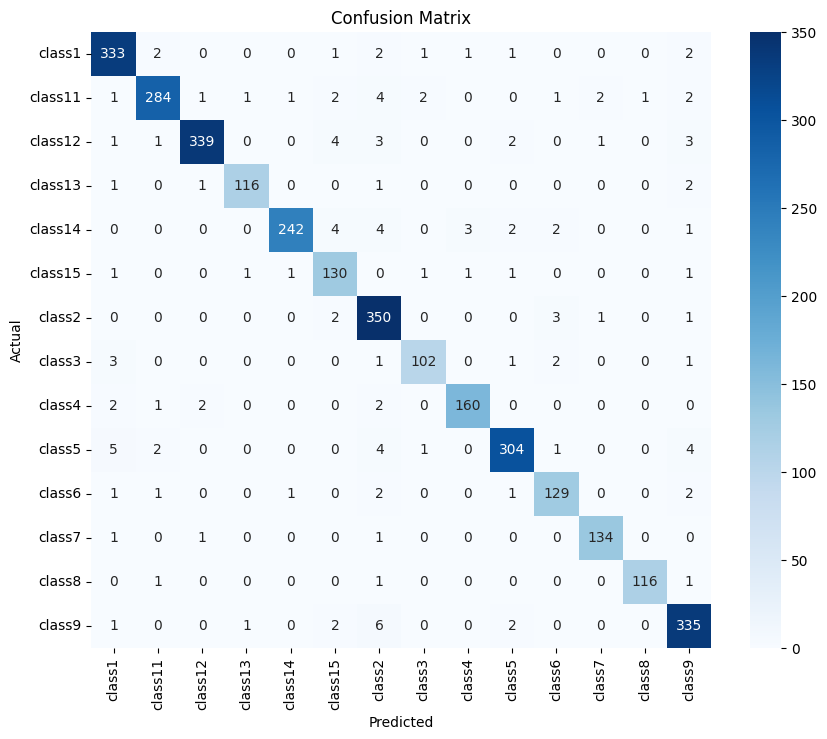

In [18]:
#ACC Y CONF MAT DE TRAIN
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_preds.append(outputs.argmax(1).cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)


f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 Score: {f1:.4f}")
print(classification_report(all_labels, all_preds, target_names=class_names))


conf_mat = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


F1 Score: 0.1823
              precision    recall  f1-score   support

      class1       0.08      0.09      0.08        76
     class11       0.34      0.27      0.30        62
     class12       0.16      0.16      0.16        77
     class13       0.08      0.08      0.08        25
     class14       0.16      0.07      0.10        56
     class15       0.13      0.23      0.17        26
      class2       0.18      0.32      0.23        66
      class3       0.11      0.06      0.08        17
      class4       0.42      0.35      0.38        43
      class5       0.19      0.16      0.18        75
      class6       0.12      0.12      0.12        26
      class7       0.21      0.14      0.17        36
      class8       0.17      0.22      0.19        23
      class9       0.22      0.20      0.21        79

    accuracy                           0.18       687
   macro avg       0.18      0.18      0.17       687
weighted avg       0.19      0.18      0.18       687



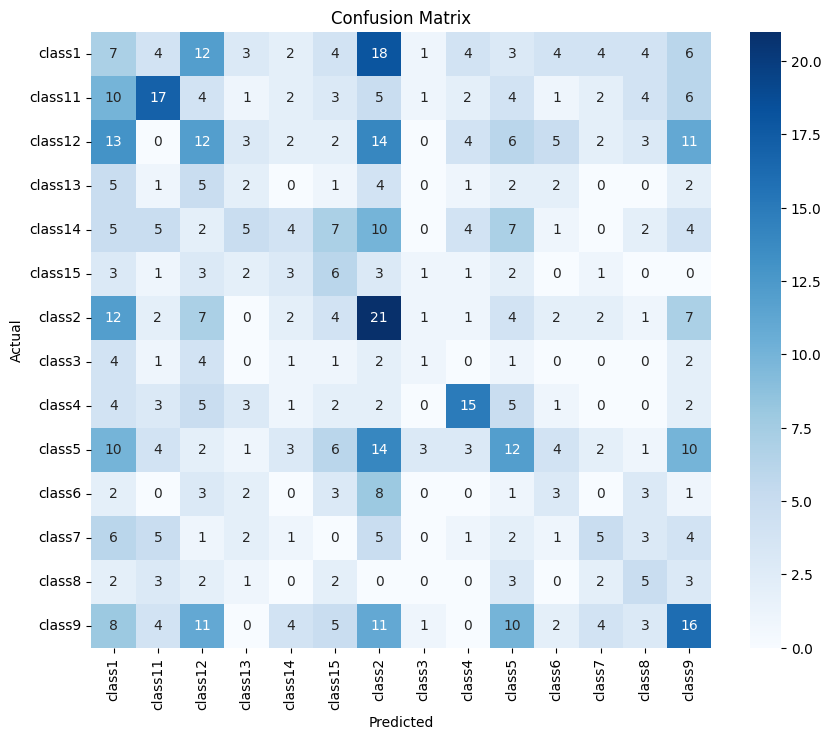

In [19]:
#ACC Y CONF MAT DE VAL
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_preds.append(outputs.argmax(1).cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)


f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 Score: {f1:.4f}")
print(classification_report(all_labels, all_preds, target_names=class_names))


conf_mat = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


F1 Score: 0.1464
              precision    recall  f1-score   support

      class1       0.16      0.21      0.18        80
     class11       0.20      0.14      0.16        66
     class12       0.13      0.13      0.13        69
     class13       0.17      0.15      0.16        27
     class14       0.12      0.11      0.11        47
     class15       0.09      0.15      0.11        26
      class2       0.13      0.18      0.15        77
      class3       0.10      0.04      0.06        24
      class4       0.30      0.18      0.23        39
      class5       0.16      0.12      0.14        83
      class6       0.13      0.10      0.11        31
      class7       0.14      0.14      0.14        29
      class8       0.11      0.19      0.14        16
      class9       0.15      0.15      0.15        74

    accuracy                           0.15       688
   macro avg       0.15      0.14      0.14       688
weighted avg       0.15      0.15      0.15       688



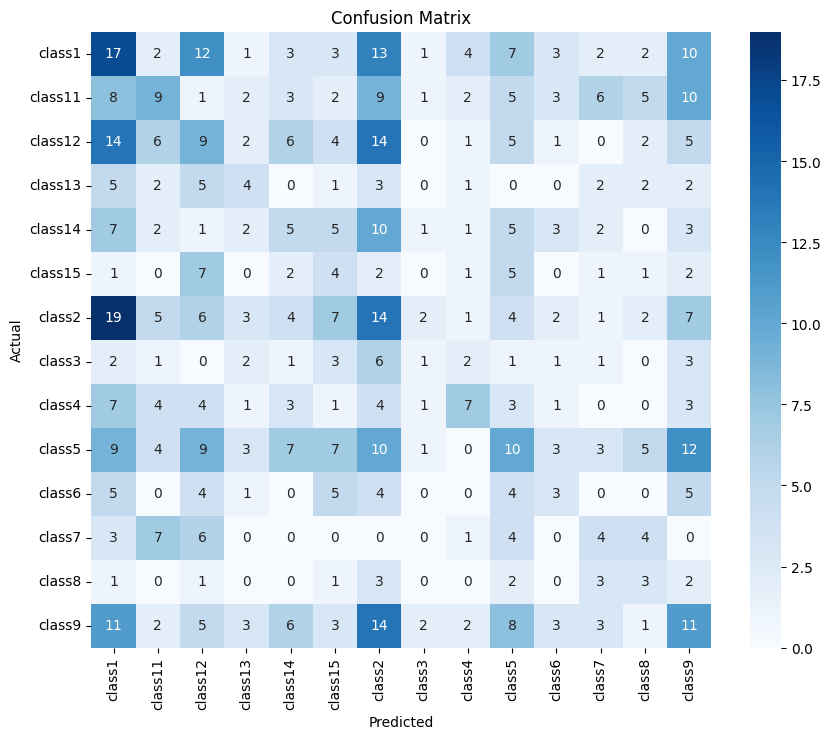

In [20]:
#ACC Y CONF MAT DE TEST
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_preds.append(outputs.argmax(1).cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)


f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 Score: {f1:.4f}")
print(classification_report(all_labels, all_preds, target_names=class_names))


conf_mat = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()